### Machine Learning (C24), Spring 2024, Project Group F
-----
# Linear Regression Models
This notebook fits linear regression models for the dataset at **df_clean.csv** and outputs a comparative data table of common regression (y-num) metrics.

Data
- y target is `'price actual'`
- X features
    - Given: national energy data, weather features from five cities (one-hot-encoded)
    - Extracted: tume variables, previous three hours of `'price actual'`
    - ➡️ **Select top 10 features from feature importance** of [XGboost_Minho.ipynb](../XGBoost/XGboost_Minho.ipynb) 

Models fitted (scikit-learn):
-  `DummyRegressor` (for baseline metrics)
1. `LinearRegression` (OLS)
2. `Ridge` (cross-validated +1SE)
3. `Lasso` (cross-validated +1SE)

Evaluation metrics:
1. MSE, RMSE, R$^2$, MAE, MAPE
2. Plots: y vs. $\hat{y}$, residuals vs. $\hat{y}$, residual historgram, Bias-Variance Tradeoff: MSE vs. alpha, **time-series and residuals**
3. Feature importance (coefficients)

In [1]:
# Import libraries
import pandas as pd
import numpy as np 

from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.pipeline import make_pipeline

from collections import defaultdict

# Visualization
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
#import plotly.express as px

# Import project functions
import sys
sys.path.append('../')
from functions import prep_split, add_model_eval, model_eval_plot, regression_coef_plot

In [2]:
# Output options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Data Preparation

Steps:
1. Drop unneeded columns ⬅️ tried options
2. Split X/y, train/test
3. Standardize X

In [3]:
df = pd.read_csv('../Data/df_clean.csv', index_col="time", parse_dates=['time'])
df.shape #(35061, 91)

(35061, 91)

In [4]:
# 1a. Options: column subsets
price_prev_cols = [col for col in df.columns if 'price_prev' in col]
time_cols = ['hour', 'weekday', 'month']
generation_cols = [col for col in df.columns if 'generation' in col or 'forecast' in col or 'load' in col]
weather_ohe_cols = [col for col in df.columns if 'weather' in col]
ahead_cols = [col for col in df.columns if 'ahead' in col]

In [5]:
# 2/3. "prep_split" includes dropping specified columns, then standardizing all remaining X (but not y)
y_col = ['price actual']
X_train, X_test, y_train, y_test = prep_split(df,
                                              columns_drop=y_col, #default: just drop y from X
                                              label=y_col,
                                              train_end_date='2017-12-31 23:00:00+00:00',
                                              hours_ahead=0) #default: don't shift y

#X_train.describe() #check: all vars have mean~0, std~1
#y_train.describe() #check: not standardized

In [6]:
# Setup model evaluation dictionary
model_eval = dict()

## 0. Baseline Dummy
- Uses scikit-learn `DummyRegressor`

In [7]:
# Baseline "dummy" prediction based on y-train mean
#y_pred_dummy = pd.Series([y_train.mean()] * len(y_test), index=y_test.index)
dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(X_train, y_train)
y_pred_dummy = dummy_model.predict(X_test)

# Calculate Test MSE etc.
model_eval = add_model_eval(model_eval, 'Baseline dummy (y_train mean)', y_test, y_pred_dummy)
pd.DataFrame(model_eval).T

,MSE,RMSE,R2,MAE,MAPE
Baseline dummy (y_train mean),204.00324,14.28297,-0.368643,11.953448,0.212781


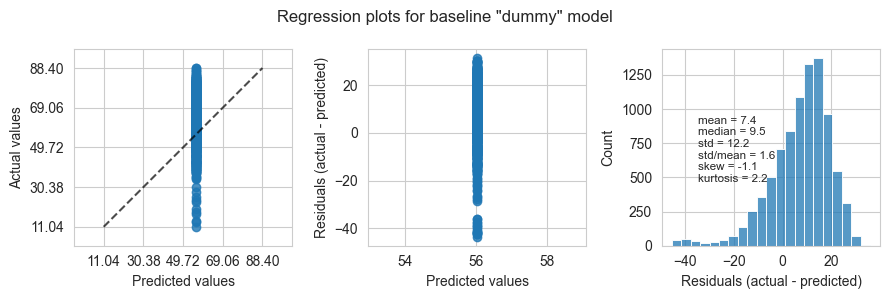

In [8]:
# Key regression plots
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
model_eval_plot(y_test, y_pred_dummy, fig, axes, 'Regression plots for baseline "dummy" model')

## 1. Ordinary Least Squares
Try three iterations of different subsets of X:
1. Original: Without extracted time nor previous price features
2. Full: original with extracted
3. **XGBoost top 10**

In [9]:
# Remove extracted variables
X_train1 = X_train.drop(columns=price_prev_cols+time_cols)
X_test1 = X_test.drop(columns=price_prev_cols+time_cols)

# 1. Create model
ols_model1 = LinearRegression() 
# 2. Fit model with training data
ols_model1.fit(X_train1, y_train)
# Check MSE-train
mean_squared_error(y_train, ols_model1.predict(X_train1))

71.09804892172373

In [10]:
# 3. Use model to predict test data
y_pred_ols1 = ols_model1.predict(X_test1)
# 4a. Evaluate
model_eval = add_model_eval(model_eval, 'Linear Regression (OLS) - original', y_test, y_pred_ols1)
pd.DataFrame(model_eval).T

,MSE,RMSE,R2,MAE,MAPE
Baseline dummy (y_train mean),204.003240,14.28297,-0.368643,11.953448,0.212781
Linear Regression (OLS) - original,68.695751,8.28829,0.539125,5.687431,0.105614


In [11]:
# All variables

# 1. Create model
ols_model2 = LinearRegression() 
# 2. Fit model with training data
ols_model2.fit(X_train, y_train)
# Check MSE-train
mean_squared_error(y_train, ols_model2.predict(X_train))

9.059619684477262

In [12]:
# 3. Use model to predict test data
y_pred_ols2 = ols_model2.predict(X_test) 
# 4a. Evaluate
model_eval = add_model_eval(model_eval, 'Linear Regression (OLS) - full', y_test, y_pred_ols2)
pd.DataFrame(model_eval).T

,MSE,RMSE,R2,MAE,MAPE
Baseline dummy (y_train mean),204.003240,14.28297,-0.368643,11.953448,0.212781
Linear Regression (OLS) - original,68.695751,8.28829,0.539125,5.687431,0.105614
Linear Regression (OLS) - full,7.797218,2.79235,0.947689,1.974839,0.035338


In [13]:
# XGBoost top 10 features and y
xg_top10 = ['price_prev_1', 'price day ahead', 'hour', 'price_prev_2', 'price_prev_3', 'forecast solar day ahead', 'generation solar', 'generation other renewable', 'temp_Madrid', 'temp_Seville']
df2 = df[xg_top10 + y_col]
df2.shape #(35061, 11)

# Re-split
X_train, X_test, y_train, y_test = prep_split(df2,
                                              columns_drop=y_col, #default: just drop y from X
                                              label=y_col,
                                              train_end_date='2017-12-31 23:00:00+00:00',
                                              hours_ahead=0) #default: don't shift y

# 1. Create model
ols_model3 = LinearRegression() 
# 2. Fit model with training data
ols_model3.fit(X_train, y_train)
# Check MSE-train
mean_squared_error(y_train, ols_model3.predict(X_train))

9.420232144472967

In [14]:
# 3. Use model to predict test data
y_pred_ols3 = ols_model3.predict(X_test) 
# 4a. Evaluate
model_eval = add_model_eval(model_eval, 'Linear Regression (OLS) - XGBoost top 10', y_test, y_pred_ols3)
pd.DataFrame(model_eval).T

,MSE,RMSE,R2,MAE,MAPE
Baseline dummy (y_train mean),204.003240,14.282970,-0.368643,11.953448,0.212781
Linear Regression (OLS) - original,68.695751,8.288290,0.539125,5.687431,0.105614
Linear Regression (OLS) - full,7.797218,2.792350,0.947689,1.974839,0.035338
Linear Regression (OLS) - XGBoost top 10,7.586404,2.754343,0.949103,1.884506,0.033580


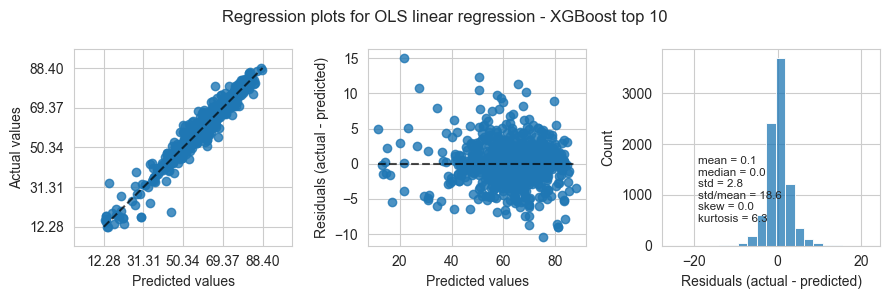

In [15]:
# 4b. Plot
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
model_eval_plot(y_test, y_pred_ols3, fig, axes, 'Regression plots for OLS linear regression - XGBoost top 10')

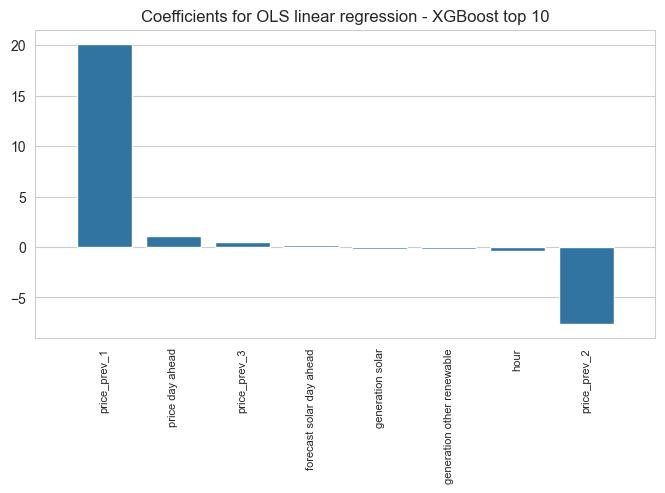

In [16]:
# 4c. Interpret
fig, axes = plt.subplots(figsize=(8, 4))
regression_coef_plot(ols_model3, fig, axes, 0.1, 'Coefficients for OLS linear regression - XGBoost top 10')

## 2. Ridge Regression
Build "best" ridge regression model by:
- Setup cross-validation with time-series splits!
    - 1st split: 2015 train ➡️ 2016 validation
    - 2nd split: 2015-16 train ➡️ 2017 validation
- Loop through alphas and save (manually since `RidgeCV` does not save K-Fold scores)
- Choose alpha using 1SE rule (ref: Lab 6)
    - Simplifed Lab 6 code using DataFrames
    - plot train MSE vs. alpha
    - RE-FIT and measure test MSE

In [17]:
# Setup time-series cross-validation
tscv = TimeSeriesSplit(n_splits=2)

# Setup alphas
ridge_scores = defaultdict(list)
ridge_scores['alphas'] = np.logspace(-5, 5, 20)

In [18]:
# Alpha parameter loop
for alpha in ridge_scores['alphas']:
    # Do CV with Ridge model
    ridge_model = Ridge(alpha=alpha)
    scores = cross_val_score(ridge_model, X_train, y_train, cv=tscv, scoring='neg_mean_squared_error')
    
    # Per-alpha: calculate scores average and SE
    ridge_scores['avg_mse'].append(-1 * np.mean(scores))
    ridge_scores['std_errors'].append(np.std(scores) / np.sqrt(len(scores)))

In [19]:
# Choose alpha based on One Standard Error Rule: min MSE + 1SE
df_ridge_scores = pd.DataFrame(ridge_scores)
within_one_std = df_ridge_scores['avg_mse'].min() + df_ridge_scores['std_errors'][df_ridge_scores['avg_mse'].idxmin()]
best_alpha_ridge = max([df_ridge_scores['alphas'][i] for i, mse in enumerate(df_ridge_scores['avg_mse']) if mse <= within_one_std])
best_alpha_ridge

20.6913808111479

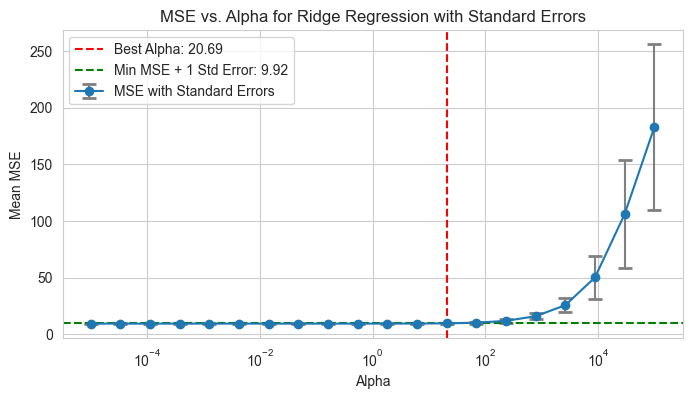

In [20]:
# Plotting MSE vs Alpha with standard error bars
fig, axes = plt.subplots(figsize=(8, 4))
plt.errorbar(ridge_scores['alphas'], ridge_scores['avg_mse'], yerr=ridge_scores['std_errors'], fmt='-o', ecolor='gray', capsize=5, capthick=2, label='MSE with Standard Errors')

# Alpha and MSE lines for chosen point
plt.axvline(x=best_alpha_ridge, color='red', linestyle='--', label=f'Best Alpha: {round(best_alpha_ridge,2)}')
plt.axhline(y=within_one_std, color='green', linestyle='--', label=f'Min MSE + 1 Std Error: {round(within_one_std,2)}')

# Plot customizations
plt.xlabel('Alpha')
plt.ylabel('Mean MSE')
plt.xscale('log')  # Alpha values are on a logarithmic scale
plt.title('MSE vs. Alpha for Ridge Regression with Standard Errors')
plt.legend()
plt.show()

In [21]:
# Ridge model with best alpha: #1. Create #2. Fit #3. Predict
best_ridge_model = Ridge(alpha=best_alpha_ridge)
best_ridge_model.fit(X_train, y_train)
y_pred_ridge = best_ridge_model.predict(X_test)

# 4a. Evaluate
model_eval = add_model_eval(model_eval, 'Ridge Regression - XGBoost top 10', y_test, y_pred_ridge)
pd.DataFrame(model_eval).T

,MSE,RMSE,R2,MAE,MAPE
Baseline dummy (y_train mean),204.003240,14.282970,-0.368643,11.953448,0.212781
Linear Regression (OLS) - original,68.695751,8.288290,0.539125,5.687431,0.105614
Linear Regression (OLS) - full,7.797218,2.792350,0.947689,1.974839,0.035338
Linear Regression (OLS) - XGBoost top 10,7.586404,2.754343,0.949103,1.884506,0.033580
Ridge Regression - XGBoost top 10,7.597017,2.756269,0.949032,1.883995,0.033580


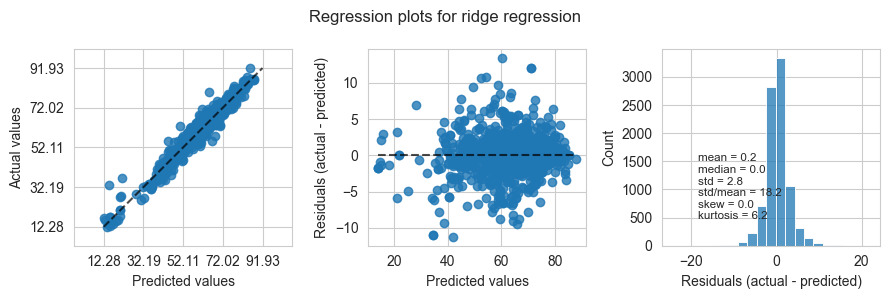

In [22]:
# 4b. Plot
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
model_eval_plot(y_test, y_pred_ridge, fig, axes, 'Regression plots for ridge regression')

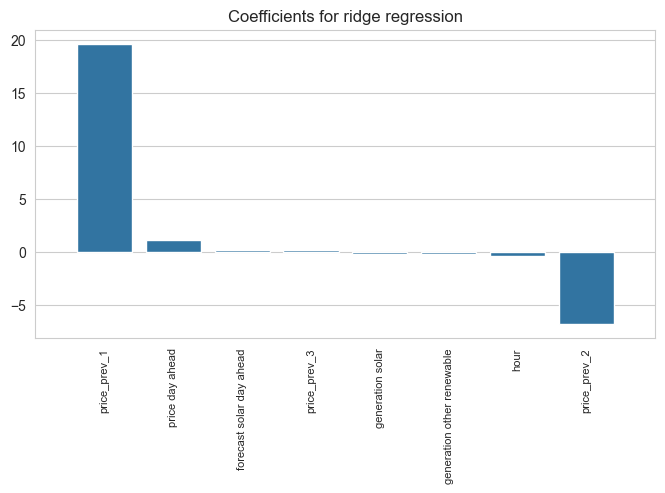

In [23]:
# 4c. Interpret
fig, axes = plt.subplots(figsize=(8, 4))
regression_coef_plot(best_ridge_model, fig, axes, 0.1, 'Coefficients for ridge regression')

## 3. Lasso Regression

In [24]:
# Setup time-series cross-validation
tscv = TimeSeriesSplit(n_splits=2)

# Setup alphas
lasso_scores = defaultdict(list)
lasso_scores['alphas'] = np.logspace(-5, 5, 20)

In [25]:
# Alpha parameter loop
for alpha in lasso_scores['alphas']:
    # Do CV with Lasso model
    lasso_model = Lasso(alpha=alpha)
    scores = cross_val_score(lasso_model, X_train, y_train, cv=tscv, scoring='neg_mean_squared_error')
    
    # Per-alpha: calculate scores average and SE
    lasso_scores['avg_mse'].append(-1 * np.mean(scores))
    lasso_scores['std_errors'].append(np.std(scores) / np.sqrt(len(scores)))

In [26]:
# Choose alpha based on One Standard Error Rule: min MSE + 1SE
df_lasso_scores = pd.DataFrame(lasso_scores)
within_one_std = df_lasso_scores['avg_mse'].min() + df_lasso_scores['std_errors'][df_lasso_scores['avg_mse'].idxmin()]
best_alpha_lasso = max([df_lasso_scores['alphas'][i] for i, mse in enumerate(df_lasso_scores['avg_mse']) if mse <= within_one_std])
best_alpha_lasso

0.04832930238571752

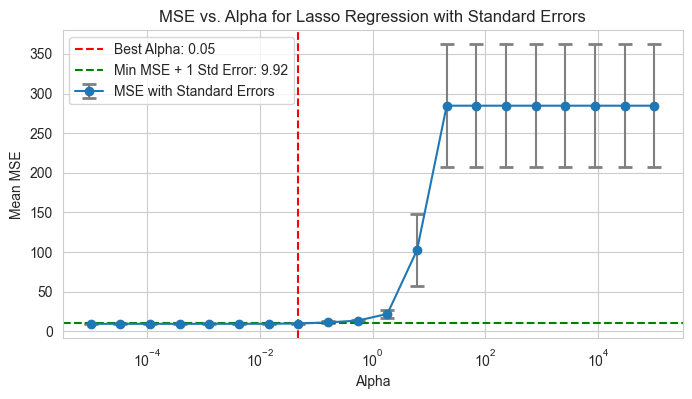

In [27]:
# Plotting MSE vs Alpha with standard error bars
fig, axes = plt.subplots(figsize=(8, 4))
plt.errorbar(lasso_scores['alphas'], lasso_scores['avg_mse'], yerr=lasso_scores['std_errors'], fmt='-o', ecolor='gray', capsize=5, capthick=2, label='MSE with Standard Errors')

# Alpha and MSE lines for chosen point
plt.axvline(x=best_alpha_lasso, color='red', linestyle='--', label=f'Best Alpha: {round(best_alpha_lasso,2)}')
plt.axhline(y=within_one_std, color='green', linestyle='--', label=f'Min MSE + 1 Std Error: {round(within_one_std,2)}')

# Plot customizations
plt.xlabel('Alpha')
plt.ylabel('Mean MSE')
plt.xscale('log')  # Alpha values are on a logarithmic scale
plt.title('MSE vs. Alpha for Lasso Regression with Standard Errors')
plt.legend()
plt.show()

In [28]:
# Ridge model with best alpha: #1. Create #2. Fit #3. Predict
best_lasso_model = Lasso(alpha=best_alpha_lasso)
best_lasso_model.fit(X_train, y_train)
y_pred_lasso = best_lasso_model.predict(X_test)

# 4a. Evaluate
model_eval = add_model_eval(model_eval, 'Lasso Regression - XGBoost top 10', y_test, y_pred_lasso)
pd.DataFrame(model_eval).T

,MSE,RMSE,R2,MAE,MAPE
Baseline dummy (y_train mean),204.003240,14.282970,-0.368643,11.953448,0.212781
Linear Regression (OLS) - original,68.695751,8.288290,0.539125,5.687431,0.105614
Linear Regression (OLS) - full,7.797218,2.792350,0.947689,1.974839,0.035338
Linear Regression (OLS) - XGBoost top 10,7.586404,2.754343,0.949103,1.884506,0.033580
Ridge Regression - XGBoost top 10,7.597017,2.756269,0.949032,1.883995,0.033580
Lasso Regression - XGBoost top 10,7.704169,2.775638,0.948313,1.887801,0.033689


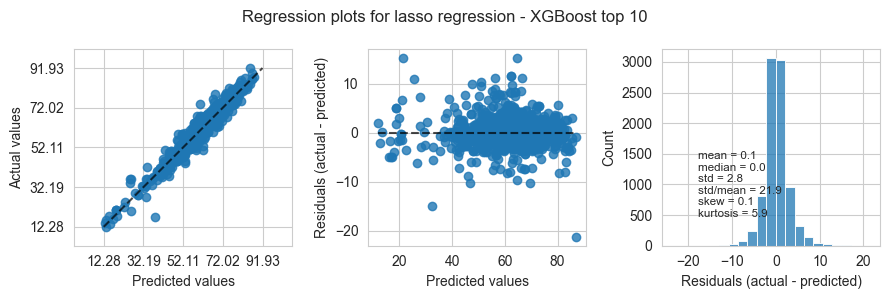

In [29]:
# 4b. Plot
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
model_eval_plot(y_test, y_pred_lasso, fig, axes, 'Regression plots for lasso regression - XGBoost top 10')

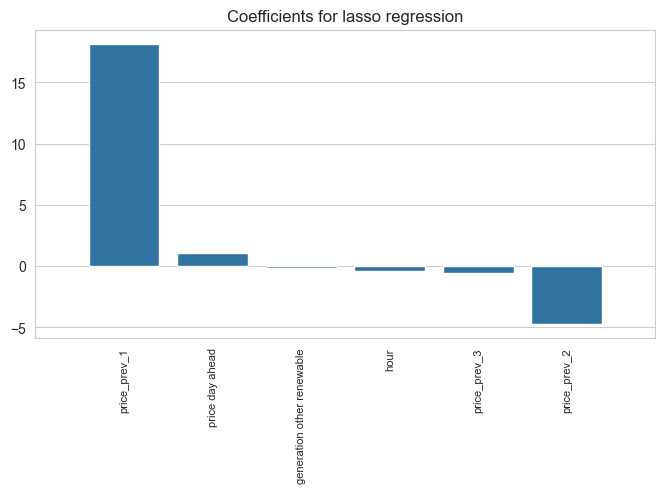

In [30]:
# 4c. Interpret
fig, axes = plt.subplots(figsize=(8, 4))
regression_coef_plot(best_lasso_model, fig, axes, 0.1, 'Coefficients for lasso regression')

## Commentary
**Observations:**
- Adding the extracted time and `'price_prev*'` variables to the original dataset **dramatically lowers the RMSE** from 8.29 to 2.79 with OLS linear regression
- Selecting only the top 10 features from XGBoost further lowers RMSE to 2.75
- Surprisingly, Ridge and Lasso regressions (cross-validated, 1SE rule) do not reduce the RMSE

**Analysis:**
- As expected, previous prices are the most useful to predict current price from the coefficient values of all models
- How to interpret?: `'price_prev_1'` has a positive infleunce but `'price_prev_2'` has a negative influence for all models

## Time-Series plots

In [31]:
# Create DataFrame to help manage plots
df_ts = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred_lasso}, index = y_test.index)
df_ts['y_residual'] = df_ts.y_true - df_ts.y_pred
# Re-add time variables
df_ts2 = df_ts.merge(df[['hour', 'weekday', 'month']], left_index=True, right_index=True, how='inner')

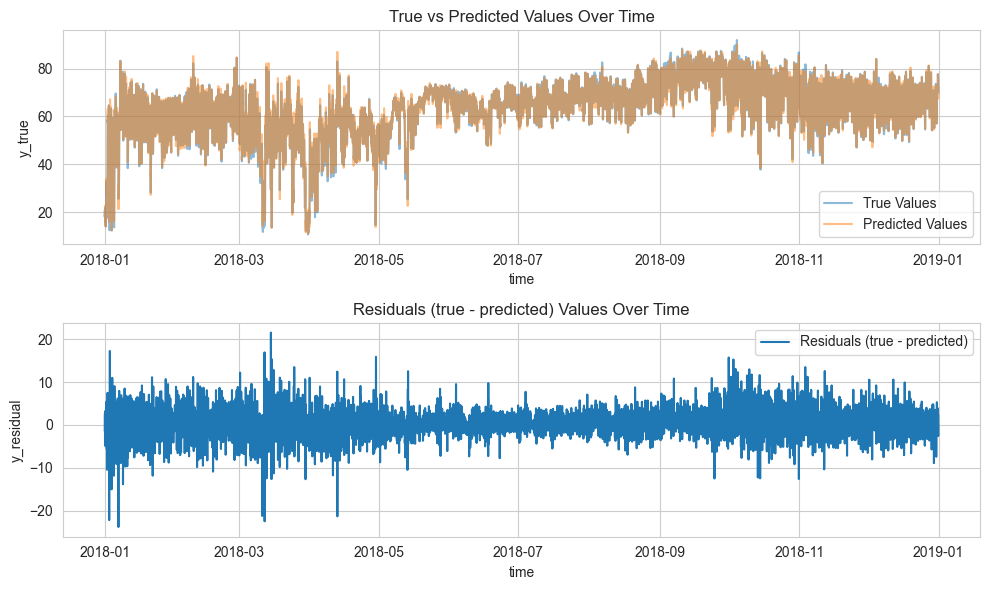

In [32]:
# Time-series line plots
fig, axs = plt.subplots(2, 1, figsize=(10, 6))

sns.lineplot(data=df_ts, x=df_ts2.index, y='y_true', label='True Values', alpha=0.5, ax=axs[0])
sns.lineplot(data=df_ts, x=df_ts2.index, y='y_pred', label='Predicted Values', alpha=0.5, ax=axs[0])
sns.lineplot(data=df_ts, x=df_ts2.index, y='y_residual', label='Residuals (true - predicted)', ax=axs[1])

axs[0].set_title('True vs Predicted Values Over Time')
axs[1].set_title('Residuals (true - predicted) Values Over Time')

plt.tight_layout()
plt.show()

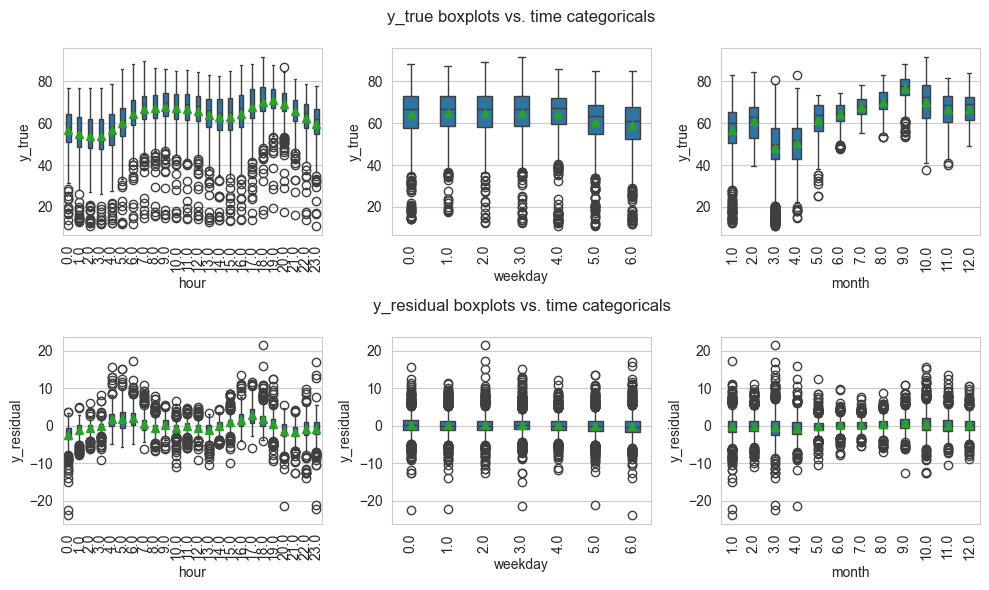

In [43]:
# Time categorical boxplots
fig, axs = plt.subplots(2, 3, figsize=(10, 6))

x_list = ['hour', 'weekday', 'month']
y_list = ['y_true', 'y_residual']
for i, y_var in enumerate(y_list):
    for j, x_var in enumerate(x_list):
        sns.boxplot(data=df_ts2, y=y_var, x=x_var, width=0.4, showmeans=True, ax=axs[i][j])
        axs[i][j].tick_params(axis='x', rotation=90)
        if j == 1:
            axs[i][j].set_title(f'{y_var} boxplots vs. time categoricals\n')

plt.tight_layout()
plt.show()

**Observations:**
- y_true
    - Hourly and weekday/weekend patterns are visible
    - Monthly trend is somewhat cyclical
- y_residual
    - The mean error (residual) only slightly changes over hours, and not much at all over days of the week or months